# Conception de l'architecture du modèle et calcul du baseline
Conception de l'architecture du modèleDans cette section, nous allons charger les métadonnées des images depuis des fichiers CSV, ajouter des colonnes pour identifier les typologies, et combiner les données en un seul DataFrame pour une analyse globale.

## Calculate Baseline

Epoch 1/40


2025-06-08 09:07:21.410574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - ETA: 0s - loss: 0.7253 - accuracy: 0.7749

2025-06-08 09:07:39.245127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 21s 54ms/step - loss: 0.7253 - accuracy: 0.7749 - val_loss: 0.3402 - val_accuracy: 0.8582
Epoch 2/40
379/379 [==============================] - 30s 78ms/step - loss: 0.3491 - accuracy: 0.8704 - val_loss: 0.2887 - val_accuracy: 0.9015
Epoch 3/40
379/379 [==============================] - 30s 79ms/step - loss: 0.2978 - accuracy: 0.8974 - val_loss: 0.2449 - val_accuracy: 0.9071
Epoch 4/40
379/379 [==============================] - 29s 77ms/step - loss: 0.2420 - accuracy: 0.9210 - val_loss: 0.2619 - val_accuracy: 0.9306
Epoch 5/40
379/379 [==============================] - 30s 79ms/step - loss: 0.3505 - accuracy: 0.9099 - val_loss: 0.6464 - val_accuracy: 0.8490
Epoch 6/40
379/379 [==============================] - 30s 79ms/step - loss: 0.4871 - accuracy: 0.9094 - val_loss: 0.9036 - val_accuracy: 0.8338
Epoch 7/40
379/379 [==============================] - 30s 79ms/step - loss: 0.5815 - accuracy: 0.9142 - val_loss: 1.3207 - val_accuracy: 0.8450
Epo

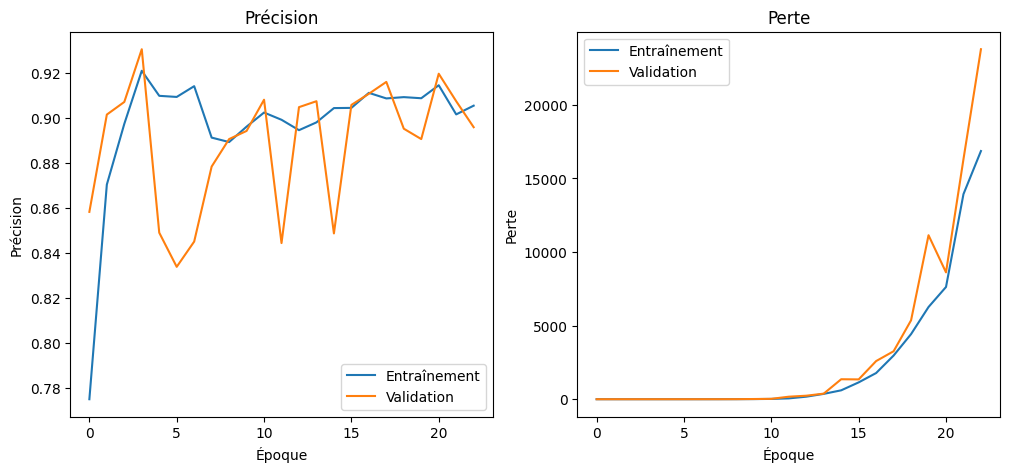

 6/95 [>.............................] - ETA: 2s

2025-06-08 09:18:42.395681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 3s 26ms/step


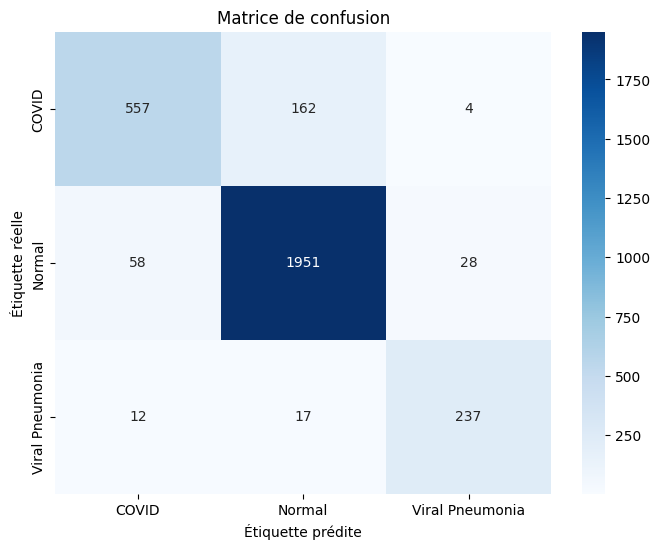

=== RAPPORT DE CLASSIFICATION ===
                 precision    recall  f1-score   support

          COVID       0.89      0.77      0.83       723
         Normal       0.92      0.96      0.94      2037
Viral Pneumonia       0.88      0.89      0.89       266

       accuracy                           0.91      3026
      macro avg       0.90      0.87      0.88      3026
   weighted avg       0.91      0.91      0.91      3026

AUC macro : 0.9783
AUC pondéré : 0.9724


In [8]:
# import os
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DOSSIER_IMAGES = "images_v3"  # Remplacez par le chemin réel de votre dataset
TAILLE_BATCH = 32
HAUTEUR_IMG = 256
LARGEUR_IMG = 256
EPOCHS = 40

# Chargement des chemins d'images et des étiquettes
chemins_images = []
etiquettes = []

for nom_classe in os.listdir(DOSSIER_IMAGES):
    chemin_classe = os.path.join(DOSSIER_IMAGES, nom_classe)
    if os.path.isdir(chemin_classe):
        for nom_image in os.listdir(chemin_classe):
            chemin_image = os.path.join(chemin_classe, nom_image)
            if os.path.isfile(chemin_image):
                chemins_images.append(chemin_image)
                etiquettes.append(nom_classe)

# Conversion des étiquettes en indices numériques
etiquette_vers_indice = {etiquette: idx for idx, etiquette in enumerate(sorted(set(etiquettes)))}
etiquettes = np.array([etiquette_vers_indice[e] for e in etiquettes])

# Chargement des images en tenseurs
toutes_images = []
for chemin in chemins_images:
    try:
        image = tf.keras.utils.load_img(chemin, target_size=(HAUTEUR_IMG, LARGEUR_IMG))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        toutes_images.append(image)
    except Exception as e:
        print(f"Avertissement : Impossible de charger l'image {chemin} : {e}")

# Conversion en tableaux NumPy
toutes_images = np.array(toutes_images)
etiquettes = np.array(etiquettes[:len(toutes_images)])  # Assurer la correspondance des tailles

# Division en ensemble d'entraînement et de validation (stratifiée)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    toutes_images, etiquettes, test_size=0.2, stratify=etiquettes, random_state=42
)

# Construction d'un modèle CNN simple
modele = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(HAUTEUR_IMG, LARGEUR_IMG, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(etiquette_vers_indice), activation='softmax')
])

# Optimiseur avec taux d'apprentissage spécifié
optimiseur = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compilation du modèle
modele.compile(optimizer=optimiseur, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définition de l'arrêt anticipé
arret_precoce = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement du modèle
historique = modele.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=TAILLE_BATCH, verbose=1, callbacks=[arret_precoce])

# Évaluation sur l'ensemble de validation
perte_val, precision_val = modele.evaluate(x_val, y_val)
print(f"Précision sur l'ensemble de validation : {precision_val:.2f}")

# Tracé des courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(historique.history['accuracy'], label='Entraînement')
plt.plot(historique.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(historique.history['loss'], label='Entraînement')
plt.plot(historique.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Prédictions sur l'ensemble de validation
y_pred_probs = modele.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcul et affichage de la matrice de confusion
mat_conf = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(mat_conf, annot=True, fmt='d', cmap='Blues', xticklabels=etiquette_vers_indice.keys(), yticklabels=etiquette_vers_indice.keys())
plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion')
plt.show()

# Rapport de classification
from sklearn.metrics import classification_report

noms_classes = [nom for nom, idx in sorted(etiquette_vers_indice.items(), key=lambda item: item[1])]
rapport = classification_report(y_val, y_pred, target_names=noms_classes, digits=2)
print("=== RAPPORT DE CLASSIFICATION ===")
print(rapport)

# Score AUC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarisation des étiquettes vraies
y_val_binarise = label_binarize(y_val, classes=list(range(len(etiquette_vers_indice))))

# Calcul de l'AUC macro et pondéré
auc_macro = roc_auc_score(y_val_binarise, y_pred_probs, average="macro", multi_class="ovr")
auc_pondere = roc_auc_score(y_val_binarise, y_pred_probs, average="weighted", multi_class="ovr")

print(f"AUC macro : {auc_macro:.4f}")
print(f"AUC pondéré : {auc_pondere:.4f}")


## Update confusion matrix a %

Epoch 1/40


2025-06-08 10:03:05.229641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - ETA: 0s - loss: 7.0897 - accuracy: 0.6305

2025-06-08 10:03:39.435761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 37s 97ms/step - loss: 7.0897 - accuracy: 0.6305 - val_loss: 0.6249 - val_accuracy: 0.7865
Epoch 2/40
379/379 [==============================] - 35s 92ms/step - loss: 3.0101 - accuracy: 0.7293 - val_loss: 0.7445 - val_accuracy: 0.7654
Epoch 3/40
379/379 [==============================] - 35s 92ms/step - loss: 0.9690 - accuracy: 0.7749 - val_loss: 1.4577 - val_accuracy: 0.6761
Epoch 4/40
379/379 [==============================] - 35s 92ms/step - loss: 0.5778 - accuracy: 0.8146 - val_loss: 0.4915 - val_accuracy: 0.8212
Epoch 5/40
379/379 [==============================] - 35s 91ms/step - loss: 0.4642 - accuracy: 0.8478 - val_loss: 0.4616 - val_accuracy: 0.8450
Epoch 6/40
379/379 [==============================] - 34s 91ms/step - loss: 0.4249 - accuracy: 0.8640 - val_loss: 0.5247 - val_accuracy: 0.8265
Epoch 7/40
379/379 [==============================] - 35s 92ms/step - loss: 0.4846 - accuracy: 0.8712 - val_loss: 2.9324 - val_accuracy: 0.7310
Epo

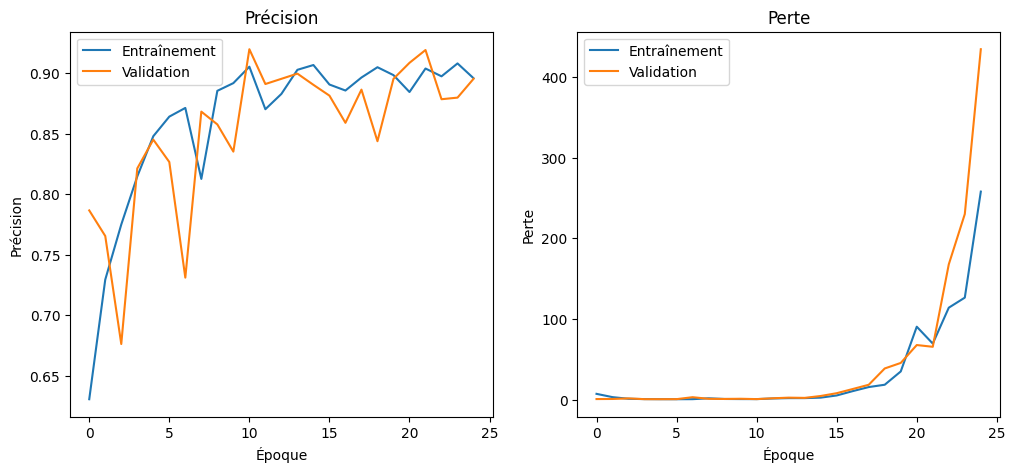

 4/95 [>.............................] - ETA: 2s

2025-06-08 10:17:38.092224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 3s 26ms/step


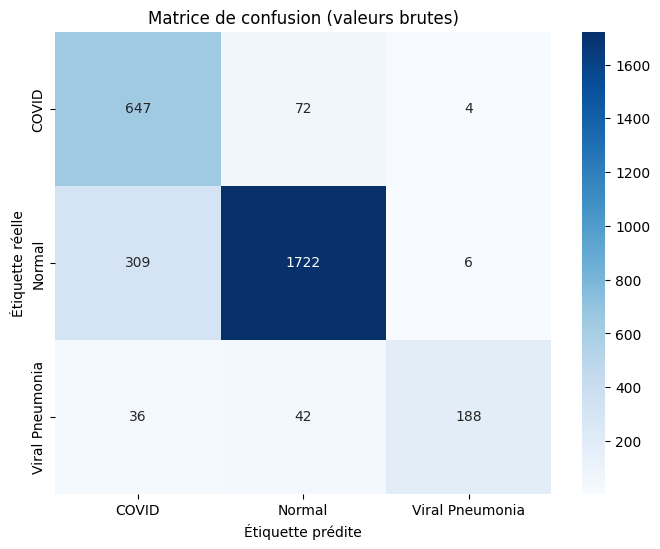

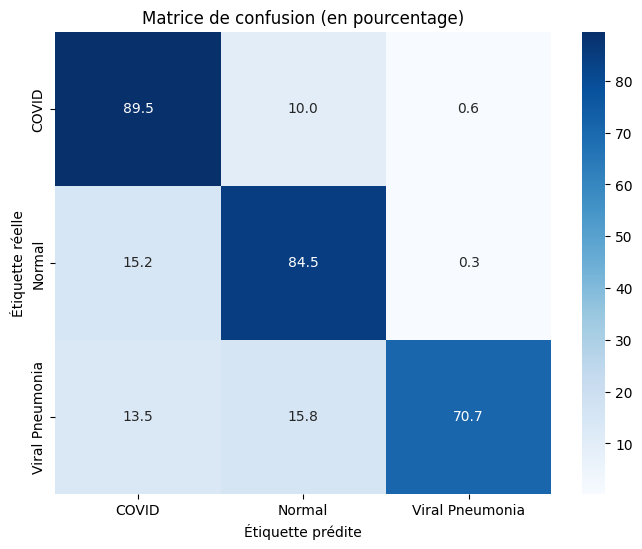

=== RAPPORT DE CLASSIFICATION ===
                 precision    recall  f1-score   support

          COVID       0.65      0.89      0.75       723
         Normal       0.94      0.85      0.89      2037
Viral Pneumonia       0.95      0.71      0.81       266

       accuracy                           0.85      3026
      macro avg       0.85      0.82      0.82      3026
   weighted avg       0.87      0.85      0.85      3026

AUC macro : 0.9544
AUC pondéré : 0.9412


In [9]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Configuration de base
DOSSIER_IMAGES = "images_v3"  # Remplacez par le chemin réel de votre dataset
TAILLE_BATCH = 32
HAUTEUR_IMG = 256
LARGEUR_IMG = 256
EPOCHS = 40

# Chargement des chemins d'images et des étiquettes
chemins_images = []
etiquettes = []

for nom_classe in os.listdir(DOSSIER_IMAGES):
    chemin_classe = os.path.join(DOSSIER_IMAGES, nom_classe)
    if os.path.isdir(chemin_classe):
        for nom_image in os.listdir(chemin_classe):
            chemin_image = os.path.join(chemin_classe, nom_image)
            if os.path.isfile(chemin_image):
                chemins_images.append(chemin_image)
                etiquettes.append(nom_classe)

# Conversion des étiquettes en indices numériques
etiquette_vers_indice = {etiquette: idx for idx, etiquette in enumerate(sorted(set(etiquettes)))}
etiquettes = np.array([etiquette_vers_indice[e] for e in etiquettes])

# Chargement des images en tenseurs
toutes_images = []
for chemin in chemins_images:
    try:
        image = tf.keras.utils.load_img(chemin, target_size=(HAUTEUR_IMG, LARGEUR_IMG))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        toutes_images.append(image)
    except Exception as e:
        print(f"Avertissement : Impossible de charger l'image {chemin} : {e}")

# Conversion en tableaux NumPy
toutes_images = np.array(toutes_images)
etiquettes = np.array(etiquettes[:len(toutes_images)])  # Assurer la correspondance des tailles

# Division en ensemble d'entraînement et de validation (stratifiée)
x_train, x_val, y_train, y_val = train_test_split(
    toutes_images, etiquettes, test_size=0.2, stratify=etiquettes, random_state=42
)

# Construction d'un modèle CNN simple
modele = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(HAUTEUR_IMG, LARGEUR_IMG, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(etiquette_vers_indice), activation='softmax')
])

# Optimiseur avec taux d'apprentissage spécifié
optimiseur = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compilation du modèle
modele.compile(optimizer=optimiseur, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définition de l'arrêt anticipé
arret_precoce = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement du modèle
historique = modele.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=TAILLE_BATCH, verbose=1, callbacks=[arret_precoce])

# Évaluation sur l'ensemble de validation
perte_val, precision_val = modele.evaluate(x_val, y_val)
print(f"Précision sur l'ensemble de validation : {precision_val:.2f}")

# Tracé des courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(historique.history['accuracy'], label='Entraînement')
plt.plot(historique.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(historique.history['loss'], label='Entraînement')
plt.plot(historique.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

# Prédictions sur l'ensemble de validation
y_pred_probs = modele.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Matrice de confusion brute
mat_conf = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(mat_conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=etiquette_vers_indice.keys(),
            yticklabels=etiquette_vers_indice.keys())
plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (valeurs brutes)')
plt.show()

# Matrice de confusion en pourcentage
mat_conf_pct = mat_conf.astype('float') / mat_conf.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(mat_conf_pct, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=etiquette_vers_indice.keys(),
            yticklabels=etiquette_vers_indice.keys())
plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (en pourcentage)')
plt.show()

# Rapport de classification
noms_classes = [nom for nom, idx in sorted(etiquette_vers_indice.items(), key=lambda item: item[1])]
rapport = classification_report(y_val, y_pred, target_names=noms_classes, digits=2)
print("=== RAPPORT DE CLASSIFICATION ===")
print(rapport)

# Score AUC
y_val_binarise = label_binarize(y_val, classes=list(range(len(etiquette_vers_indice))))
auc_macro = roc_auc_score(y_val_binarise, y_pred_probs, average="macro", multi_class="ovr")
auc_pondere = roc_auc_score(y_val_binarise, y_pred_probs, average="weighted", multi_class="ovr")
print(f"AUC macro : {auc_macro:.4f}")
print(f"AUC pondéré : {auc_pondere:.4f}")


## Premiers essaies avec Inception (avec transfert learning)

Epoch 1/10


2025-06-06 20:14:54.742900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.5721 - accuracy: 0.8221

2025-06-06 20:15:41.015874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 56s 102ms/step - loss: 0.5721 - accuracy: 0.8221 - val_loss: 24.8476 - val_accuracy: 0.1390
Epoch 2/10
528/528 [==============================] - 35s 66ms/step - loss: 0.3397 - accuracy: 0.8737 - val_loss: 25.0784 - val_accuracy: 0.1340
Epoch 3/10
528/528 [==============================] - 34s 65ms/step - loss: 0.3134 - accuracy: 0.8843 - val_loss: 22.5921 - val_accuracy: 0.1380
Epoch 4/10
528/528 [==============================] - 34s 65ms/step - loss: 0.3124 - accuracy: 0.8822 - val_loss: 21.5407 - val_accuracy: 0.1335
Epoch 5/10
528/528 [==============================] - 34s 65ms/step - loss: 0.2898 - accuracy: 0.8909 - val_loss: 21.5804 - val_accuracy: 0.1357
Epoch 6/10
528/528 [==============================] - 34s 65ms/step - loss: 0.2765 - accuracy: 0.8971 - val_loss: 22.1248 - val_accuracy: 0.1371
Epoch 7/10
528/528 [==============================] - 34s 65ms/step - loss: 0.2755 - accuracy: 0.8959 - val_loss: 22.5904 - val_accuracy: 0.

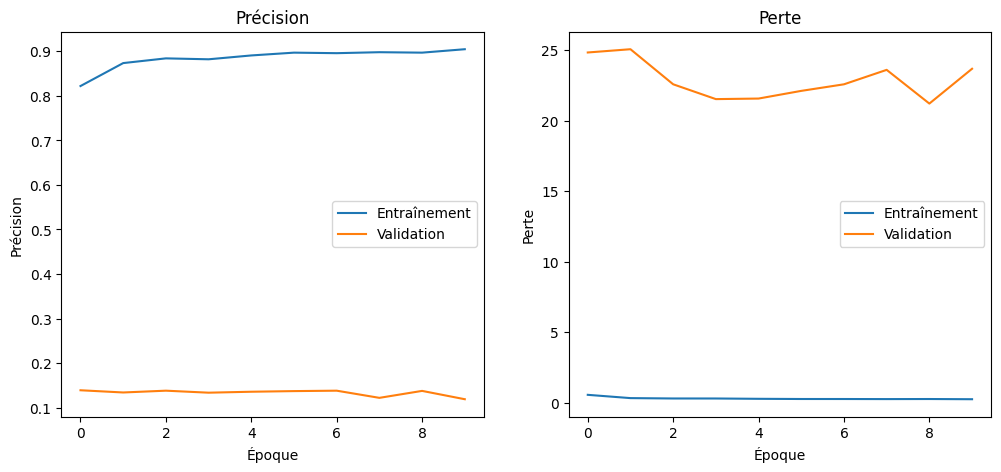

2025-06-06 20:21:07.470520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 7s 49ms/step


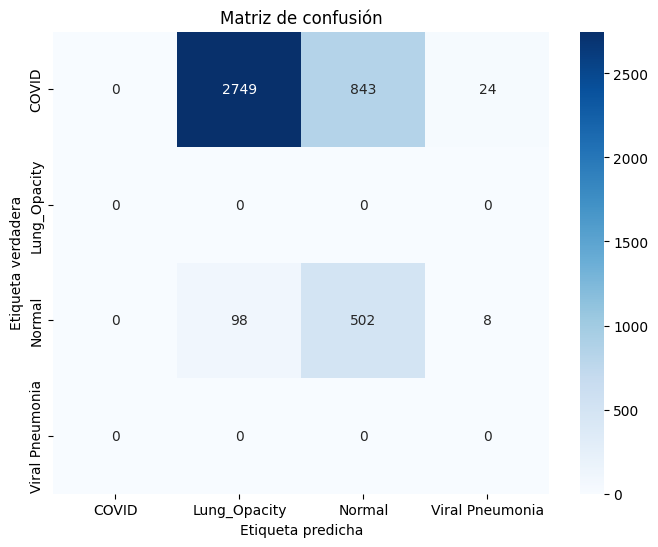

132/132 [==============================] - 7s 50ms/step


/var/folders/d8/_k93xk4n1rx9gm8w0zxwdtsh0000gn/T/ipykernel_1572/1126822453.py:133: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


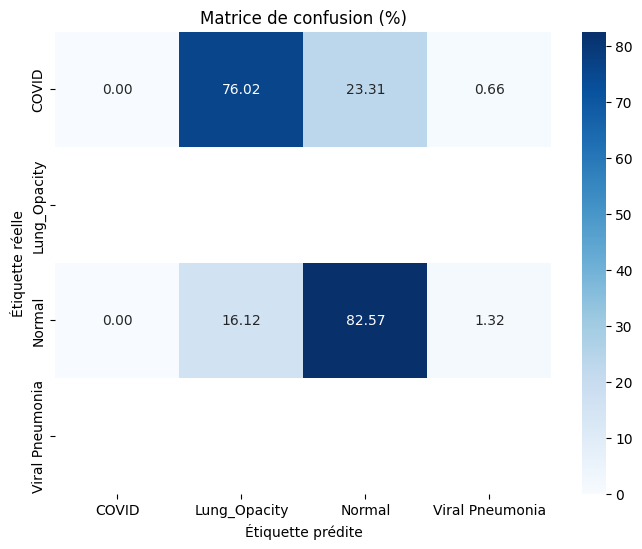

=== MÉTRIQUES DE CLASSIFICATION ===
                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00      3616
   Lung_Opacity       0.00      0.00      0.00         0
         Normal       0.37      0.83      0.51       608
Viral Pneumonia       0.00      0.00      0.00         0

       accuracy                           0.12      4224
      macro avg       0.09      0.21      0.13      4224
   weighted avg       0.05      0.12      0.07      4224



/Users/roberto/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roberto/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roberto/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roberto/

In [8]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v2"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 10

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Charger le modèle InceptionV3 pré-entraîné
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Geler les couches de base du modèle
base_model.trainable = False

# Construction du modèle avec InceptionV3 comme base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définir l'arrêt anticipé
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
train_size = int(0.8 * len(all_images))
x_train, x_val = all_images[:train_size], all_images[train_size:]
y_train, y_val = labels[:train_size], labels[train_size:]

# Entraînement du modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stopping])

# Évaluation sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Précision sur validation: {val_accuracy:.2f}")

# Tracer les courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Obtener las predicciones del modelo en el conjunto de validación
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión')
plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les prédictions du modèle
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Normaliser par ligne (par classe réelle) et multiplier par 100 pour obtenir les pourcentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Étiquettes des classes en français (à adapter si besoin)
class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]

# Afficher la matrice de confusion en pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (%)')
plt.show()

# Rapport de classification
rapport = classification_report(y_val, y_pred, target_names=class_names, digits=2)
print("=== MÉTRIQUES DE CLASSIFICATION ===")
print(rapport)



Dans la seconde implémentation, trois éléments changent par rapport à la première :

(1) la séparation des données est faite avec train_test_split en stratifiant selon les classes, assurant ainsi un équilibre entre classes dans l’entraînement et la validation ;

(2) les couches du modèle InceptionV3 ne sont pas gelées, donc toutes les couches sont entraînables, ce qui permet un ajustement plus fin aux données ;

(3) le nombre d’époques est augmenté à 40, offrant au modèle plus d’opportunités pour apprendre.

Epoch 1/40


2025-06-06 20:22:30.620839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.8033

2025-06-06 20:24:34.616973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 137s 251ms/step - loss: 0.6216 - accuracy: 0.8033 - val_loss: 2.3113 - val_accuracy: 0.7675
Epoch 2/40
528/528 [==============================] - 129s 244ms/step - loss: 0.3235 - accuracy: 0.8903 - val_loss: 0.5791 - val_accuracy: 0.8800
Epoch 3/40
528/528 [==============================] - 129s 244ms/step - loss: 0.2719 - accuracy: 0.9083 - val_loss: 0.5433 - val_accuracy: 0.8828
Epoch 4/40
528/528 [==============================] - 129s 244ms/step - loss: 0.2182 - accuracy: 0.9238 - val_loss: 1.0670 - val_accuracy: 0.6660
Epoch 5/40
528/528 [==============================] - 128s 243ms/step - loss: 0.2012 - accuracy: 0.9306 - val_loss: 0.6495 - val_accuracy: 0.8539
Epoch 6/40
528/528 [==============================] - 128s 242ms/step - loss: 0.2142 - accuracy: 0.9282 - val_loss: 0.9076 - val_accuracy: 0.8087
Epoch 7/40
528/528 [==============================] - 127s 241ms/step - loss: 0.1655 - accuracy: 0.9442 - val_loss: 0.7489 - val_accura

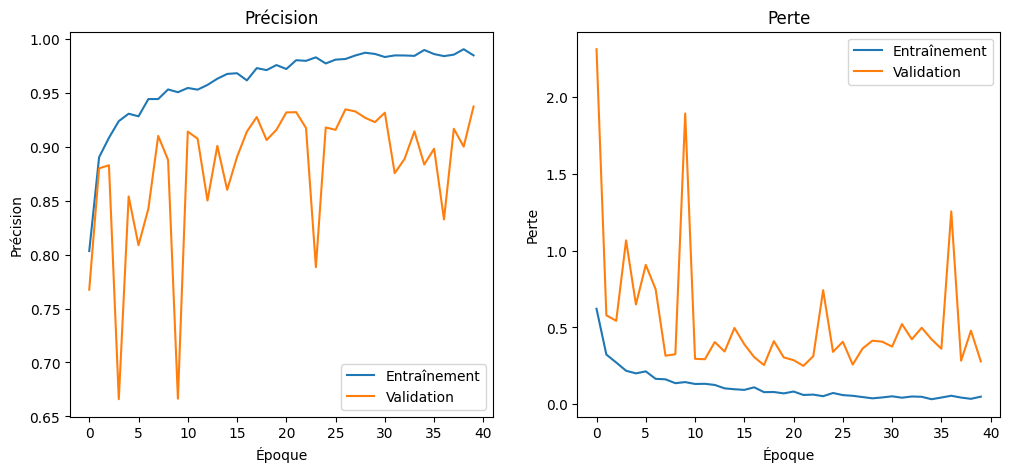

2025-06-06 21:49:28.952460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 11s 73ms/step


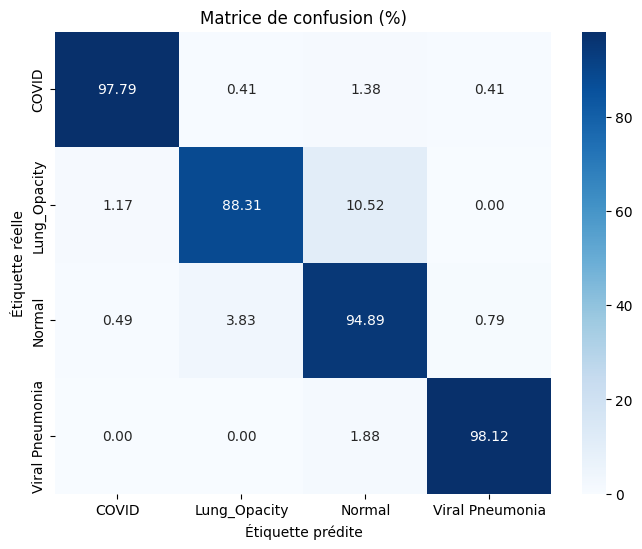

=== MÉTRIQUES DE CLASSIFICATION ===
                 precision    recall  f1-score   support

          COVID       0.97      0.98      0.97       723
   Lung_Opacity       0.93      0.88      0.91      1198
         Normal       0.93      0.95      0.94      2037
Viral Pneumonia       0.93      0.98      0.96       266

       accuracy                           0.94      4224
      macro avg       0.94      0.95      0.94      4224
   weighted avg       0.94      0.94      0.94      4224



In [9]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v2"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
#train_size = int(0.8 * len(all_images))
#x_train, x_val = all_images[:train_size], all_images[train_size:]
#y_train, y_val = labels[:train_size], labels[train_size:]

from sklearn.model_selection import train_test_split

# División estratificada: asegura que cada clase esté representada proporcionalmente
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)


# Charger InceptionV3 sans transfert d'apprentissage (sans geler les couches)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# Construcción del modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Compiler el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définir l'arrêt anticipé
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stopping])

# Évaluation sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Précision sur validation: {val_accuracy:.2f}")

# Tracer les courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les prédictions du modèle
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Normaliser par ligne (par classe réelle) et multiplier par 100 pour obtenir les pourcentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Étiquettes des classes en français (à adapter si besoin)
class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]

# Afficher la matrice de confusion en pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (%)')
plt.show()

# Rapport de classification
rapport = classification_report(y_val, y_pred, target_names=class_names, digits=2)
print("=== MÉTRIQUES DE CLASSIFICATION ===")
print(rapport)



Optimisation du LR

Epoch 1/40


2025-06-07 09:58:13.017266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.8890

2025-06-07 09:59:59.351297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 116s 211ms/step - loss: 0.3074 - accuracy: 0.8890 - val_loss: 0.2148 - val_accuracy: 0.9228
Epoch 2/40
528/528 [==============================] - 108s 203ms/step - loss: 0.1618 - accuracy: 0.9444 - val_loss: 0.3374 - val_accuracy: 0.8608
Epoch 3/40
528/528 [==============================] - 107s 202ms/step - loss: 0.1210 - accuracy: 0.9582 - val_loss: 0.2484 - val_accuracy: 0.9176
Epoch 4/40
528/528 [==============================] - 106s 201ms/step - loss: 0.1018 - accuracy: 0.9641 - val_loss: 0.2725 - val_accuracy: 0.9181
Epoch 5/40
528/528 [==============================] - 106s 201ms/step - loss: 0.0923 - accuracy: 0.9688 - val_loss: 0.4197 - val_accuracy: 0.8643
Epoch 6/40
528/528 [==============================] - 106s 200ms/step - loss: 0.0845 - accuracy: 0.9709 - val_loss: 0.2951 - val_accuracy: 0.9062
Epoch 7/40
528/528 [==============================] - 106s 201ms/step - loss: 0.0681 - accuracy: 0.9774 - val_loss: 0.2775 - val_accura

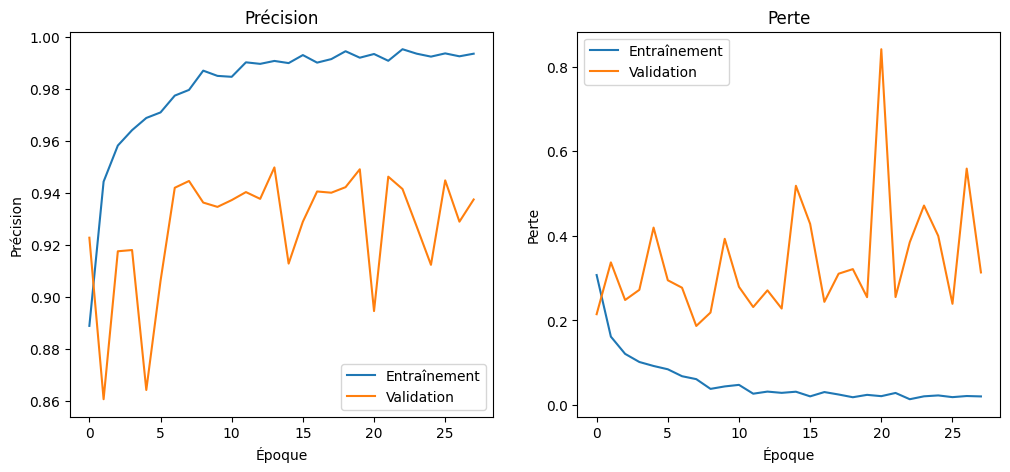

2025-06-07 10:48:02.908860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 7s 49ms/step


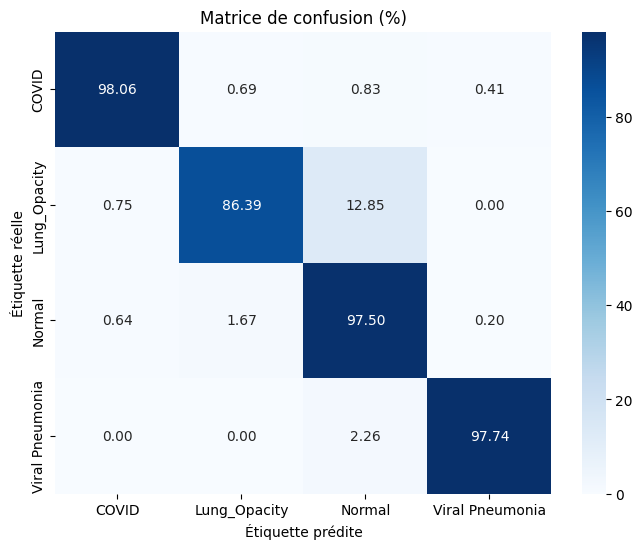

=== MÉTRIQUES DE CLASSIFICATION ===
                 precision    recall  f1-score   support

          COVID       0.97      0.98      0.98       723
   Lung_Opacity       0.96      0.86      0.91      1198
         Normal       0.92      0.97      0.95      2037
Viral Pneumonia       0.97      0.98      0.98       266

       accuracy                           0.94      4224
      macro avg       0.96      0.95      0.95      4224
   weighted avg       0.95      0.94      0.94      4224



In [11]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v2"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
#train_size = int(0.8 * len(all_images))
#x_train, x_val = all_images[:train_size], all_images[train_size:]
#y_train, y_val = labels[:train_size], labels[train_size:]

from sklearn.model_selection import train_test_split

# División estratificada: asegura que cada clase esté representada proporcionalmente
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)


# Charger InceptionV3 sans transfert d'apprentissage (sans geler les couches)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# Construcción del modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Usar un optimizador con el learning rate especificado
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00016298024493664572)

# Compiler el modelo
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définir l'arrêt anticipé
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stopping])

# Évaluation sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Précision sur validation: {val_accuracy:.2f}")

# Tracer les courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les prédictions du modèle
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Normaliser par ligne (par classe réelle) et multiplier par 100 pour obtenir les pourcentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Étiquettes des classes en français (à adapter si besoin)
class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]

# Afficher la matrice de confusion en pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (%)')
plt.show()

# Rapport de classification
rapport = classification_report(y_val, y_pred, target_names=class_names, digits=2)
print("=== MÉTRIQUES DE CLASSIFICATION ===")
print(rapport)


Ajout couche proposé 1024

Epoch 1/40


2025-06-07 10:49:23.045006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.8641

2025-06-07 10:51:10.231382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 119s 212ms/step - loss: 0.4075 - accuracy: 0.8641 - val_loss: 0.1855 - val_accuracy: 0.9358
Epoch 2/40
528/528 [==============================] - 108s 204ms/step - loss: 0.2004 - accuracy: 0.9336 - val_loss: 0.2028 - val_accuracy: 0.9261
Epoch 3/40
528/528 [==============================] - 107s 202ms/step - loss: 0.1413 - accuracy: 0.9541 - val_loss: 0.2578 - val_accuracy: 0.9107
Epoch 4/40
528/528 [==============================] - 107s 202ms/step - loss: 0.1230 - accuracy: 0.9563 - val_loss: 0.2037 - val_accuracy: 0.9361
Epoch 5/40
528/528 [==============================] - 106s 201ms/step - loss: 0.0924 - accuracy: 0.9685 - val_loss: 0.2842 - val_accuracy: 0.9176
Epoch 6/40
132/132 [==============================] - 7s 52ms/step - loss: 0.1855 - accuracy: 0.9358
Précision sur validation: 0.94


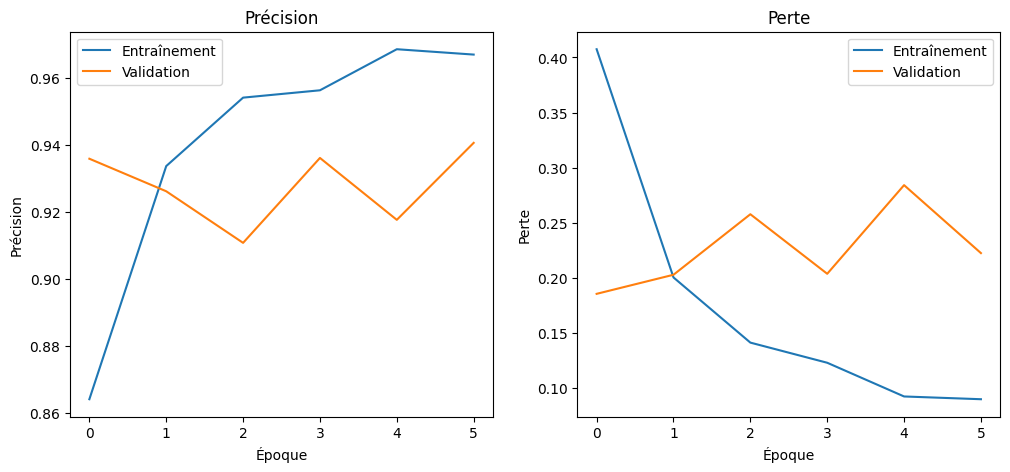

2025-06-07 11:00:21.557473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 7s 50ms/step


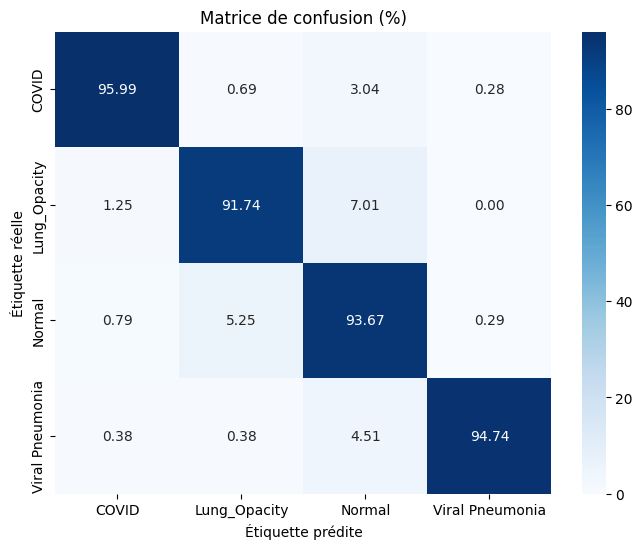

=== MÉTRIQUES DE CLASSIFICATION ===
                 precision    recall  f1-score   support

          COVID       0.96      0.96      0.96       723
   Lung_Opacity       0.91      0.92      0.91      1198
         Normal       0.94      0.94      0.94      2037
Viral Pneumonia       0.97      0.95      0.96       266

       accuracy                           0.94      4224
      macro avg       0.94      0.94      0.94      4224
   weighted avg       0.94      0.94      0.94      4224



In [12]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v2"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
#train_size = int(0.8 * len(all_images))
#x_train, x_val = all_images[:train_size], all_images[train_size:]
#y_train, y_val = labels[:train_size], labels[train_size:]

from sklearn.model_selection import train_test_split

# División estratificada: asegura que cada clase esté representada proporcionalmente
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)


# Charger InceptionV3 sans transfert d'apprentissage (sans geler les couches)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# Construcción del modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Usar un optimizador con el learning rate especificado
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00016298024493664572)

# Compiler el modelo
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définir l'arrêt anticipé
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stopping])

# Évaluation sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Précision sur validation: {val_accuracy:.2f}")

# Tracer les courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les prédictions du modèle
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Normaliser par ligne (par classe réelle) et multiplier par 100 pour obtenir les pourcentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Étiquettes des classes en français (à adapter si besoin)
class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]

# Afficher la matrice de confusion en pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (%)')
plt.show()

# Rapport de classification
rapport = classification_report(y_val, y_pred, target_names=class_names, digits=2)
print("=== MÉTRIQUES DE CLASSIFICATION ===")
print(rapport)



Test Transfer Learning

Epoch 1/40


2025-06-07 11:01:38.042573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.8746 - accuracy: 0.6817

2025-06-07 11:02:24.220858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 59s 107ms/step - loss: 0.8746 - accuracy: 0.6817 - val_loss: 0.6720 - val_accuracy: 0.7559
Epoch 2/40
528/528 [==============================] - 53s 100ms/step - loss: 0.6752 - accuracy: 0.7528 - val_loss: 0.8986 - val_accuracy: 0.7197
Epoch 3/40
528/528 [==============================] - 52s 99ms/step - loss: 0.6039 - accuracy: 0.7824 - val_loss: 0.6581 - val_accuracy: 0.7696
Epoch 4/40
528/528 [==============================] - 51s 97ms/step - loss: 0.5682 - accuracy: 0.7922 - val_loss: 0.6656 - val_accuracy: 0.7706
Epoch 5/40
528/528 [==============================] - 51s 97ms/step - loss: 0.5626 - accuracy: 0.7960 - val_loss: 0.7040 - val_accuracy: 0.7666
Epoch 6/40
528/528 [==============================] - 52s 99ms/step - loss: 0.5338 - accuracy: 0.8036 - val_loss: 0.6808 - val_accuracy: 0.7744
Epoch 7/40
528/528 [==============================] - 50s 95ms/step - loss: 0.5279 - accuracy: 0.8092 - val_loss: 0.6303 - val_accuracy: 0.7872
E

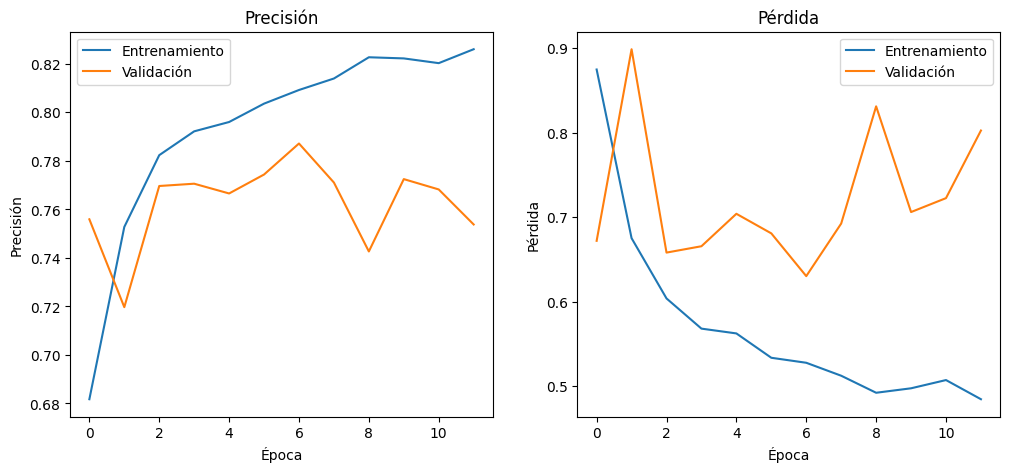

2025-06-07 11:12:12.868865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 12s 49ms/step


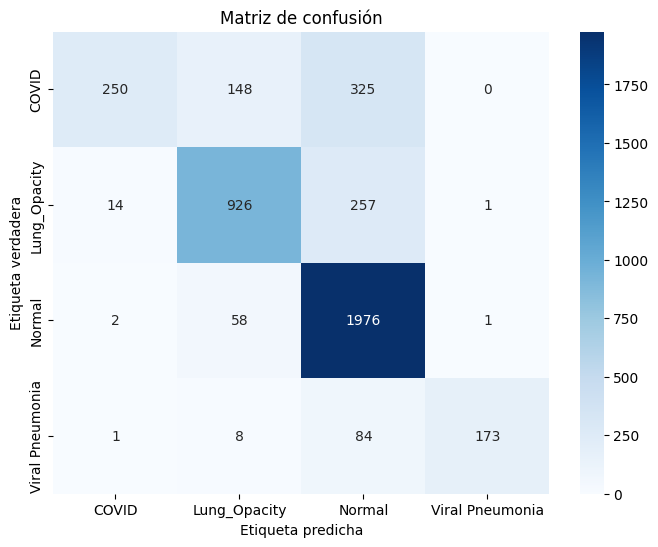

=== MÉTRICAS DE CLASIFICACIÓN ===
                 precision    recall  f1-score   support

          COVID       0.94      0.35      0.51       723
   Lung_Opacity       0.81      0.77      0.79      1198
         Normal       0.75      0.97      0.84      2037
Viral Pneumonia       0.99      0.65      0.78       266

       accuracy                           0.79      4224
      macro avg       0.87      0.68      0.73      4224
   weighted avg       0.81      0.79      0.77      4224



In [13]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Configuración
DATASET_DIR = "images_v2"
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Cargar rutas de imágenes y etiquetas
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Convertir etiquetas a índices
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Cargar imágenes como tensores
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0
        all_images.append(image)
    except Exception as e:
        print(f"Advertencia: no se pudo cargar {image_path}: {e}")

# Convertir a arrays de NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])

# División estratificada
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Transfer learning con InceptionV3
base_model = tf.keras.applications.InceptionV3(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Congelar capas del modelo base

# Construcción del modelo con capas superiores personalizadas
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Compilación
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluación
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Precisión en validación: {val_accuracy:.2f}")

# Gráficos de precisión y pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida')
plt.show()

# Predicciones y métricas
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión')
plt.show()

class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]
report = classification_report(y_val, y_pred, target_names=class_names, digits=2)
print("=== MÉTRICAS DE CLASIFICACIÓN ===")
print(report)

with open("classification_report.txt", "w") as f:
    f.write("=== MÉTRICAS DE CLASIFICACIÓN ===\n")
    f.write(report)


Suppresion de la class Lung_Opacity du dataset --> seulement 3 classes analyses

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v3"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
#train_size = int(0.8 * len(all_images))
#x_train, x_val = all_images[:train_size], all_images[train_size:]
#y_train, y_val = labels[:train_size], labels[train_size:]

from sklearn.model_selection import train_test_split

# División estratificada: asegura que cada clase esté representada proporcionalmente
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)


# Charger InceptionV3 sans transfert d'apprentissage (sans geler les couches)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# Construcción del modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Compiler el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définir l'arrêt anticipé
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stopping])

# Évaluation sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Précision sur validation: {val_accuracy:.2f}")

# Tracer les courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les prédictions du modèle
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Normaliser par ligne (par classe réelle) et multiplier par 100 pour obtenir les pourcentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Étiquettes des classes en français (à adapter si besoin)
class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]

# Afficher la matrice de confusion en pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (%)')
plt.show()

# Rapport de classification
rapport = classification_report(y_val, y_pred, target_names=class_names, digits=4)
print("=== MÉTRIQUES DE CLASSIFICATION ===")
print(rapport)


2025-06-10 17:43:26.567804: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-06-10 17:43:26.567828: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-06-10 17:43:26.567832: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-06-10 17:43:26.568357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-10 17:43:26.568576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/40


2025-06-10 17:43:35.709348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8881

2025-06-10 17:44:52.076837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 84s 212ms/step - loss: 0.3386 - accuracy: 0.8881 - val_loss: 0.1918 - val_accuracy: 0.9491
Epoch 2/40
379/379 [==============================] - 76s 201ms/step - loss: 0.1416 - accuracy: 0.9536 - val_loss: 0.1425 - val_accuracy: 0.9508
Epoch 3/40
379/379 [==============================] - 76s 201ms/step - loss: 0.1229 - accuracy: 0.9582 - val_loss: 0.1874 - val_accuracy: 0.9498
Epoch 4/40
214/379 [===============>..............] - ETA: 31s - loss: 0.0894 - accuracy: 0.9725

Analyse des parametres utilisés

In [10]:
# import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v3"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
#train_size = int(0.8 * len(all_images))
#x_train, x_val = all_images[:train_size], all_images[train_size:]
#y_train, y_val = labels[:train_size], labels[train_size:]

from sklearn.model_selection import train_test_split

# División estratificada: asegura que cada clase esté representada proporcionalmente
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)


# Charger InceptionV3 sans transfert d'apprentissage (sans geler les couches)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Añadir aquí
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"Nombre total de paramètres : {total_params:,}")
print(f"Nombre de paramètres entraînés : {trainable_params:,}")
print(f"Nombre de paramètres non entraînés : {non_trainable_params:,}")


Nombre total de paramètres : 22,328,099
Nombre de paramètres entraînés : 22,293,667
Nombre de paramètres non entraînés : 34,432


Optimisation

Epoch 1/40


2025-06-07 12:04:13.060544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9477

2025-06-07 12:05:29.382528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 84s 211ms/step - loss: 0.1450 - accuracy: 0.9477 - val_loss: 0.0954 - val_accuracy: 0.9696
Epoch 2/40
379/379 [==============================] - 76s 199ms/step - loss: 0.0593 - accuracy: 0.9807 - val_loss: 0.0791 - val_accuracy: 0.9765
Epoch 3/40
379/379 [==============================] - 76s 199ms/step - loss: 0.0334 - accuracy: 0.9892 - val_loss: 0.0892 - val_accuracy: 0.9693
Epoch 4/40
379/379 [==============================] - 75s 199ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.1055 - val_accuracy: 0.9772
Epoch 5/40
379/379 [==============================] - 76s 200ms/step - loss: 0.0297 - accuracy: 0.9888 - val_loss: 0.0748 - val_accuracy: 0.9752
Epoch 6/40
379/379 [==============================] - 76s 200ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0379 - val_accuracy: 0.9884
Epoch 7/40
379/379 [==============================] - 76s 199ms/step - loss: 0.0180 - accuracy: 0.9948 - val_loss: 0.0469 - val_accuracy: 0.9

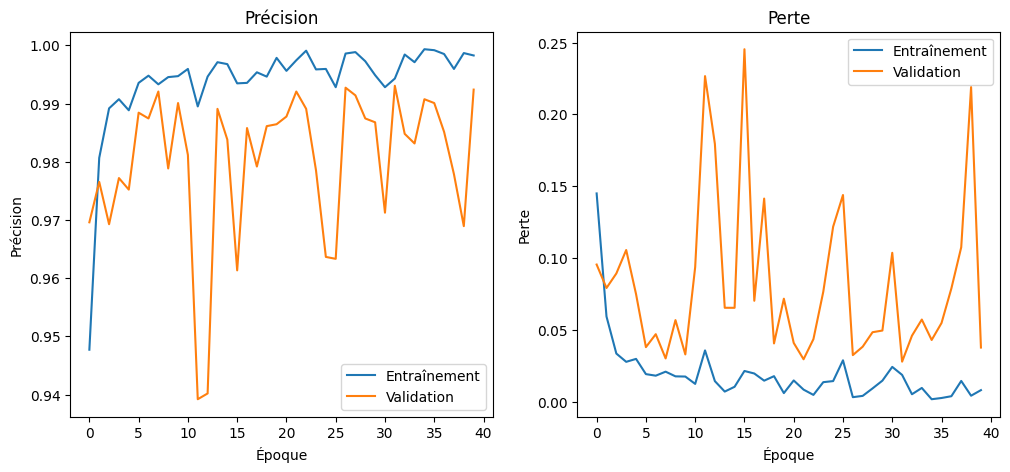

2025-06-07 12:54:48.232006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 6s 54ms/step


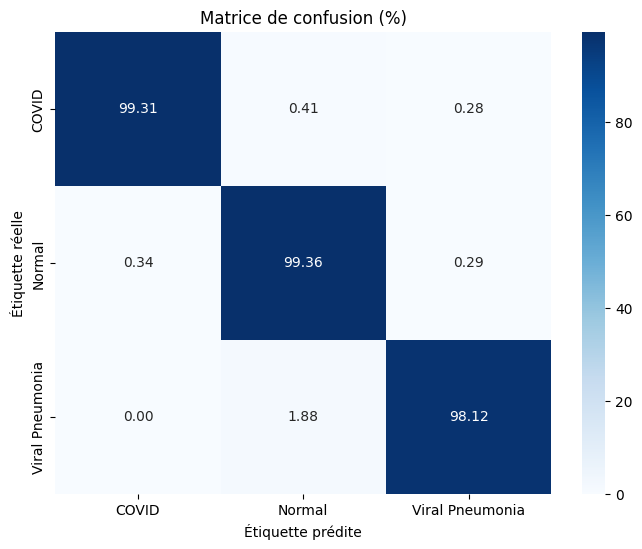

=== MÉTRIQUES DE CLASSIFICATION ===
                 precision    recall  f1-score   support

          COVID       0.99      0.99      0.99       723
         Normal       1.00      0.99      0.99      2037
Viral Pneumonia       0.97      0.98      0.98       266

       accuracy                           0.99      3026
      macro avg       0.99      0.99      0.99      3026
   weighted avg       0.99      0.99      0.99      3026



In [15]:
# import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v3"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
#train_size = int(0.8 * len(all_images))
#x_train, x_val = all_images[:train_size], all_images[train_size:]
#y_train, y_val = labels[:train_size], labels[train_size:]

from sklearn.model_selection import train_test_split

# División estratificada: asegura que cada clase esté representada proporcionalmente
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)


# Charger InceptionV3 sans transfert d'apprentissage (sans geler les couches)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# Construcción del modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Usar un optimizador con el learning rate especificado
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00016298024493664572)

# Compiler el modelo
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définir l'arrêt anticipé
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stopping])

# Évaluation sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Précision sur validation: {val_accuracy:.2f}")

# Tracer les courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les prédictions du modèle
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Normaliser par ligne (par classe réelle) et multiplier par 100 pour obtenir les pourcentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Étiquettes des classes en français (à adapter si besoin)
class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]

# Afficher la matrice de confusion en pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (%)')
plt.show()

# Rapport de classification
rapport = classification_report(y_val, y_pred, target_names=class_names, digits=2)
print("=== MÉTRIQUES DE CLASSIFICATION ===")
print(rapport)


Changement de LR a 0.000014395752695088314

In [ ]:
# import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v3"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
#train_size = int(0.8 * len(all_images))
#x_train, x_val = all_images[:train_size], all_images[train_size:]
#y_train, y_val = labels[:train_size], labels[train_size:]

from sklearn.model_selection import train_test_split

# División estratificada: asegura que cada clase esté representada proporcionalmente
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)


# Charger InceptionV3 sans transfert d'apprentissage (sans geler les couches)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# Construcción del modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Usar un optimizador con el learning rate especificado
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000014395752695088314)

# Compiler el modelo
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définir l'arrêt anticipé
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stopping])

# Évaluation sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Précision sur validation: {val_accuracy:.2f}")

# Tracer les courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Obtener las predicciones del modelo en el conjunto de validación
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión')
plt.show()

from sklearn.metrics import classification_report

# Obtener predicciones
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generar reporte de clasificación
class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]
report = classification_report(y_val, y_pred, target_names=class_names, digits=4)
print("=== MÉTRICAS DE CLASSIFICATION ===")
print(report)

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarizar etiquetas verdaderas (one-hot)
y_val_binarized = label_binarize(y_val, classes=list(range(len(label_to_index))))

# Calcular el AUC multiclase
auc_macro = roc_auc_score(y_val_binarized, y_pred_probs, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_val_binarized, y_pred_probs, average="weighted", multi_class="ovr")

print(f"AUC macro: {auc_macro:.4f}")
print(f"AUC ponderado: {auc_weighted:.4f}")


Ajout 2 couches 4096

Epoch 1/40


2025-06-07 13:40:48.815408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.8382

2025-06-07 13:42:14.764462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 94s 237ms/step - loss: 0.4059 - accuracy: 0.8382 - val_loss: 0.2714 - val_accuracy: 0.8995
Epoch 2/40
379/379 [==============================] - 76s 201ms/step - loss: 0.1172 - accuracy: 0.9598 - val_loss: 0.0965 - val_accuracy: 0.9673
Epoch 3/40
379/379 [==============================] - 76s 201ms/step - loss: 0.0564 - accuracy: 0.9801 - val_loss: 0.0816 - val_accuracy: 0.9739
Epoch 4/40
379/379 [==============================] - 76s 201ms/step - loss: 0.0284 - accuracy: 0.9907 - val_loss: 0.1087 - val_accuracy: 0.9716
Epoch 5/40
379/379 [==============================] - 76s 201ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.0902 - val_accuracy: 0.9736
Epoch 6/40
379/379 [==============================] - 76s 201ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0661 - val_accuracy: 0.9808
Epoch 7/40
379/379 [==============================] - 76s 201ms/step - loss: 0.0136 - accuracy: 0.9954 - val_loss: 0.0779 - val_accuracy: 0.9

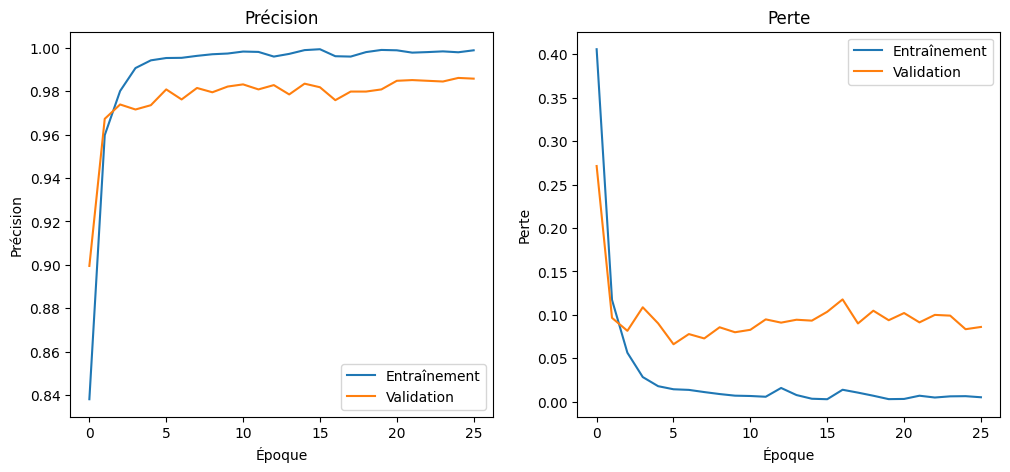

2025-06-07 14:14:11.572939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 6s 55ms/step


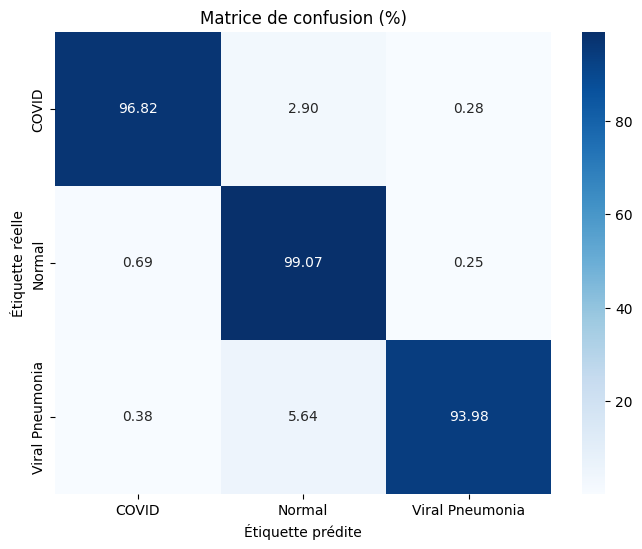

=== MÉTRIQUES DE CLASSIFICATION ===
                 precision    recall  f1-score   support

          COVID       0.98      0.97      0.97       723
         Normal       0.98      0.99      0.99      2037
Viral Pneumonia       0.97      0.94      0.96       266

       accuracy                           0.98      3026
      macro avg       0.98      0.97      0.97      3026
   weighted avg       0.98      0.98      0.98      3026



In [17]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v3"  # Remplacez par le chemin réel de votre dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Chargement des images et des étiquettes avec vérification d'existence
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement des images en tenseur
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Avertissement: Impossible de charger l'image {image_path}: {e}")

# Conversion des listes en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Assurer la correspondance des tailles

# Diviser les données en ensemble de formation et de validation (80/20 par exemple)
#train_size = int(0.8 * len(all_images))
#x_train, x_val = all_images[:train_size], all_images[train_size:]
#y_train, y_val = labels[:train_size], labels[train_size:]

from sklearn.model_selection import train_test_split

# División estratificada: asegura que cada clase esté representada proporcionalmente
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)


# Charger InceptionV3 sans transfert d'apprentissage (sans geler les couches)
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

# Construcción del modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Usar un optimizador con el learning rate especificado
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000014395752695088314)

# Compiler el modelo
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Définir l'arrêt anticipé
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[early_stopping])

# Évaluation sur l'ensemble de validation
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Précision sur validation: {val_accuracy:.2f}")

# Tracer les courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.title('Précision')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte')

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les prédictions du modèle
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Normaliser par ligne (par classe réelle) et multiplier par 100 pour obtenir les pourcentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Étiquettes des classes en français (à adapter si besoin)
class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]

# Afficher la matrice de confusion en pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Étiquette prédite')
plt.ylabel('Étiquette réelle')
plt.title('Matrice de confusion (%)')
plt.show()

# Rapport de classification
rapport = classification_report(y_val, y_pred, target_names=class_names, digits=2)
print("=== MÉTRIQUES DE CLASSIFICATION ===")
print(rapport)


Test Transfer Learning

Epoch 1/40


2025-06-07 14:15:04.091283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.7735

2025-06-07 14:15:34.847320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 41s 102ms/step - loss: 0.5923 - accuracy: 0.7735 - val_loss: 0.5186 - val_accuracy: 0.8176
Epoch 2/40
379/379 [==============================] - 39s 102ms/step - loss: 0.4170 - accuracy: 0.8415 - val_loss: 0.4101 - val_accuracy: 0.8490
Epoch 3/40
379/379 [==============================] - 38s 99ms/step - loss: 0.3719 - accuracy: 0.8589 - val_loss: 0.3152 - val_accuracy: 0.8790
Epoch 4/40
379/379 [==============================] - 38s 99ms/step - loss: 0.3443 - accuracy: 0.8683 - val_loss: 0.3090 - val_accuracy: 0.8814
Epoch 5/40
379/379 [==============================] - 38s 101ms/step - loss: 0.3110 - accuracy: 0.8809 - val_loss: 0.3060 - val_accuracy: 0.8860
Epoch 6/40
379/379 [==============================] - 38s 100ms/step - loss: 0.3054 - accuracy: 0.8817 - val_loss: 0.3086 - val_accuracy: 0.8853
Epoch 7/40
379/379 [==============================] - 38s 100ms/step - loss: 0.3061 - accuracy: 0.8867 - val_loss: 0.2598 - val_accuracy: 0.893

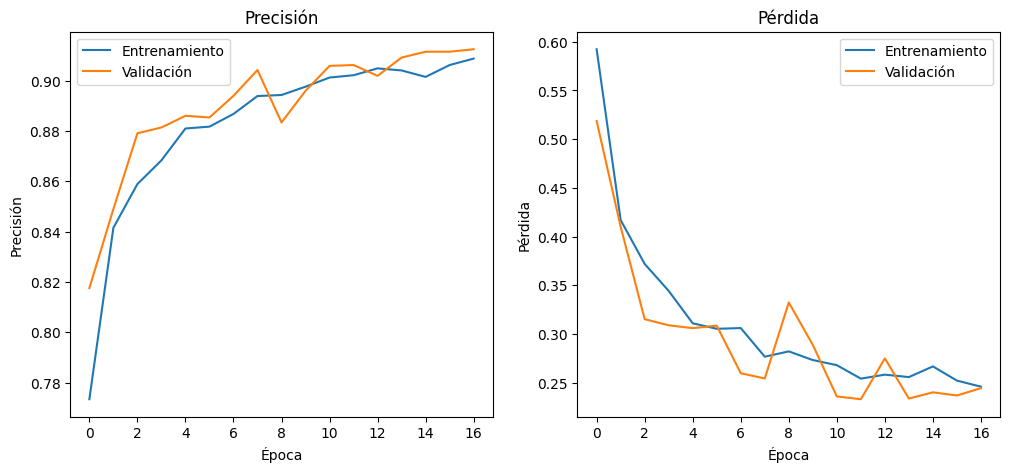

2025-06-07 14:25:42.954154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 8s 76ms/step


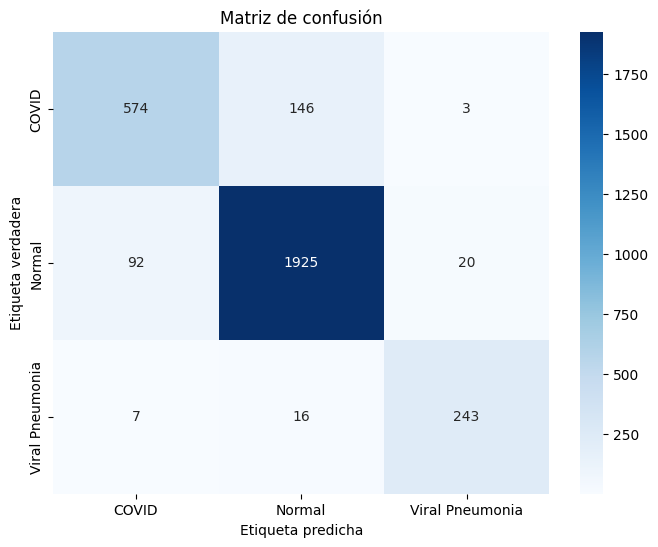

=== MÉTRICAS DE CLASIFICACIÓN ===
                 precision    recall  f1-score   support

          COVID       0.85      0.79      0.82       723
         Normal       0.92      0.95      0.93      2037
Viral Pneumonia       0.91      0.91      0.91       266

       accuracy                           0.91      3026
      macro avg       0.90      0.88      0.89      3026
   weighted avg       0.90      0.91      0.91      3026



In [18]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Configuración
DATASET_DIR = "images_v3"
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS = 40

# Cargar rutas de imágenes y etiquetas
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Convertir etiquetas a índices
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Cargar imágenes como tensores
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0
        all_images.append(image)
    except Exception as e:
        print(f"Advertencia: no se pudo cargar {image_path}: {e}")

# Convertir a arrays de NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])

# División estratificada
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Transfer learning con InceptionV3
base_model = tf.keras.applications.InceptionV3(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Congelar capas del modelo base

# Construcción del modelo con capas superiores personalizadas
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_to_index), activation='softmax')
])

# Compilación
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluación
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Precisión en validación: {val_accuracy:.2f}")

# Gráficos de precisión y pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida')
plt.show()

# Predicciones y métricas
y_pred_probs = model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión')
plt.show()

class_names = [name for name, idx in sorted(label_to_index.items(), key=lambda item: item[1])]
report = classification_report(y_val, y_pred, target_names=class_names, digits=2)
print("=== MÉTRICAS DE CLASIFICACIÓN ===")
print(report)

with open("classification_report.txt", "w") as f:
    f.write("=== MÉTRICAS DE CLASIFICACIÓN ===\n")
    f.write(report)

Autre adaptation Transfert Learning

Epoch 1/20


2025-06-07 19:29:23.098306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.7311

2025-06-07 19:30:09.834656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 59s 108ms/step - loss: 0.6900 - accuracy: 0.7311 - val_loss: 0.5150 - val_accuracy: 0.8134
Epoch 2/20
528/528 [==============================] - 51s 97ms/step - loss: 0.5111 - accuracy: 0.8025 - val_loss: 0.4709 - val_accuracy: 0.8298
Epoch 3/20
528/528 [==============================] - 51s 97ms/step - loss: 0.4717 - accuracy: 0.8213 - val_loss: 0.4511 - val_accuracy: 0.8326
Epoch 4/20
528/528 [==============================] - 54s 102ms/step - loss: 0.4431 - accuracy: 0.8314 - val_loss: 0.4400 - val_accuracy: 0.8371
Epoch 5/20
528/528 [==============================] - 54s 102ms/step - loss: 0.4279 - accuracy: 0.8353 - val_loss: 0.4311 - val_accuracy: 0.8402
Epoch 6/20
528/528 [==============================] - 53s 101ms/step - loss: 0.4116 - accuracy: 0.8440 - val_loss: 0.4466 - val_accuracy: 0.8345
Epoch 7/20
528/528 [==============================] - 54s 101ms/step - loss: 0.4133 - accuracy: 0.8449 - val_loss: 0.4192 - val_accuracy: 0.845

Epoch 21/40


2025-06-07 19:47:29.115759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.8815

2025-06-07 19:48:06.850044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 49s 84ms/step - loss: 0.3246 - accuracy: 0.8815 - val_loss: 0.3466 - val_accuracy: 0.8774
Epoch 22/40
528/528 [==============================] - 41s 78ms/step - loss: 0.2144 - accuracy: 0.9232 - val_loss: 0.3366 - val_accuracy: 0.8830
Epoch 23/40
528/528 [==============================] - 41s 79ms/step - loss: 0.1487 - accuracy: 0.9458 - val_loss: 0.3068 - val_accuracy: 0.8937
Epoch 24/40
528/528 [==============================] - 41s 78ms/step - loss: 0.1060 - accuracy: 0.9627 - val_loss: 0.4163 - val_accuracy: 0.8845
Epoch 25/40
528/528 [==============================] - 41s 78ms/step - loss: 0.0742 - accuracy: 0.9751 - val_loss: 0.3663 - val_accuracy: 0.8925
Epoch 26/40
528/528 [==============================] - 41s 78ms/step - loss: 0.0498 - accuracy: 0.9828 - val_loss: 0.3540 - val_accuracy: 0.9013
Epoch 27/40
528/528 [==============================] - 41s 78ms/step - loss: 0.0284 - accuracy: 0.9914 - val_loss: 0.4116 - val_accuracy: 0.88

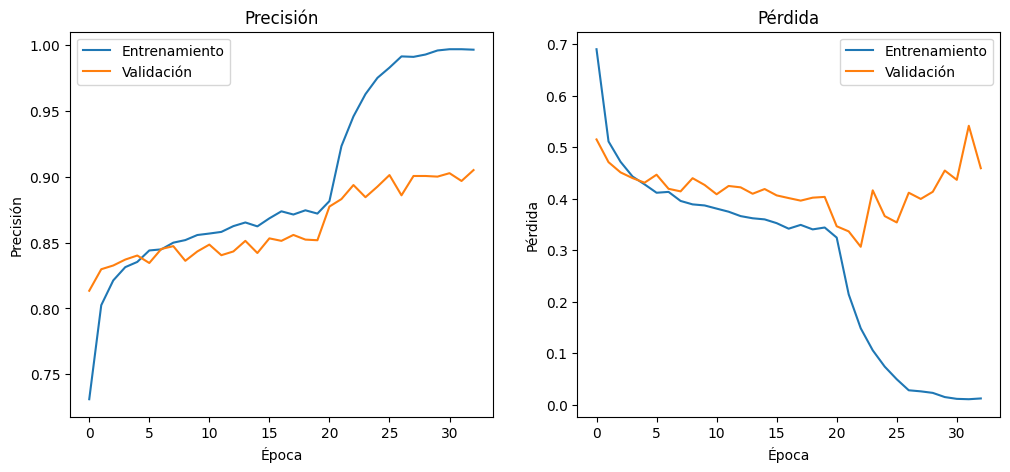

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Configuración básica
DATASET_DIR = "images_v2"  # Ruta del dataset
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
EPOCHS_INITIAL = 20    # Entrenamiento solo del clasificador
EPOCHS_FINE_TUNE = 20  # Entrenamiento con fine-tuning
TOTAL_EPOCHS = EPOCHS_INITIAL + EPOCHS_FINE_TUNE

# Cargar imágenes y etiquetas
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Etiquetas numéricas
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Cargar imágenes como tensores normalizados
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0
        all_images.append(image)
    except Exception as e:
        print(f"Aviso: No se pudo cargar {image_path}: {e}")

all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # Aseguramos tamaños

# División estratificada
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Cargar InceptionV3 preentrenado y congelarlo
base_model = tf.keras.applications.InceptionV3(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Crear el modelo
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(label_to_index), activation='softmax')(x)
model = models.Model(inputs, outputs)

# Compilar
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00016298024493664572)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar solo el clasificador (base_model congelado)
history_initial = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS_INITIAL,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# --- FINE TUNING ---
# Descongelar parte de InceptionV3
base_model.trainable = True

# Opcional: congelar las primeras capas (por ejemplo, hasta la capa 249 de 311)
fine_tune_at = 249
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar de nuevo con un learning rate más pequeño
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continuar entrenamiento (fine-tuning)
history_fine = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_initial.epoch[-1]+1,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"Precisión en validación: {val_accuracy:.2f}")

# --- Gráficas ---
def plot_training(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    plt.figure(figsize=(12, 5))
    
    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Entrenamiento')
    plt.plot(val_acc, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión')
    
    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Entrenamiento')
    plt.plot(val_loss, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida')
    
    plt.show()

plot_training(history_initial, history_fine)


## Keras Tunner

Reloading Tuner from tuner_logs/inceptionv3_no_transfer/tuner0.json

🎯 Mejores hiperparámetros encontrados:
- Número de unidades en la capa densa: 256
- Dropout: 0.40
- Learning rate: 0.00016

📈 Top 5 configuraciones:
Modelo 1: unidades=256, dropout=0.40, lr=0.00016
Modelo 2: unidades=192, dropout=0.30, lr=0.00043
Modelo 3: unidades=128, dropout=0.50, lr=0.00015
Modelo 4: unidades=192, dropout=0.30, lr=0.00016
Modelo 5: unidades=256, dropout=0.40, lr=0.00016


Epoch 1/10


2025-06-07 19:57:41.829460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.7332 - accuracy: 0.7381

2025-06-07 19:59:25.817152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 115s 206ms/step - loss: 0.7332 - accuracy: 0.7381 - val_loss: 1.6912 - val_accuracy: 0.4569
Epoch 2/10
528/528 [==============================] - 105s 199ms/step - loss: 0.4892 - accuracy: 0.8196 - val_loss: 0.4572 - val_accuracy: 0.8407
Epoch 3/10
528/528 [==============================] - 105s 199ms/step - loss: 0.4010 - accuracy: 0.8540 - val_loss: 0.3982 - val_accuracy: 0.8591
Epoch 4/10
528/528 [==============================] - 105s 199ms/step - loss: 0.3287 - accuracy: 0.8781 - val_loss: 0.3763 - val_accuracy: 0.8632
Epoch 5/10
528/528 [==============================] - 105s 199ms/step - loss: 0.3038 - accuracy: 0.8892 - val_loss: 0.4717 - val_accuracy: 0.8388
Epoch 6/10
528/528 [==============================] - 105s 199ms/step - loss: 0.2776 - accuracy: 0.8967 - val_loss: 0.3052 - val_accuracy: 0.8890
Epoch 7/10
528/528 [==============================] - 105s 199ms/step - loss: 0.2568 - accuracy: 0.9078 - val_loss: 0.4642 - val_accura

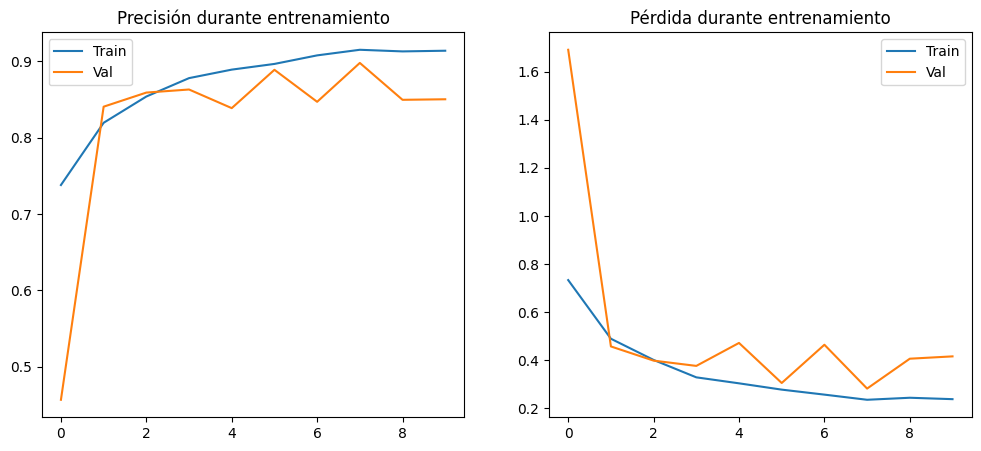

Results summary
Results in tuner_logs/inceptionv3_no_transfer
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
units: 256
dropout: 0.4
lr: 0.00016298024493664572
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.8989109992980957

Trial 0025 summary
Hyperparameters:
units: 192
dropout: 0.3
lr: 0.000432025255103857
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.8958333134651184

Trial 0028 summary
Hyperparameters:
units: 128
dropout: 0.5
lr: 0.00015470211328683808
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8792613744735718

Trial 0017 summary
Hyperparameters:
units: 192
dropout: 0.3
lr: 0.0001578641743310332
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.8776041865348816

Trial 0021 summary
Hyperparameters:
units: 256
dropout: 0.4
lr

In [3]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_tuner as kt

# Configuración
DATASET_DIR = "images_v2"
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 32
EPOCHS = 10

# Cargar imágenes y etiquetas
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0
        all_images.append(image)
    except Exception as e:
        print(f"Aviso: No se pudo cargar {image_path}: {e}")

all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])

# División estratificada
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Definición del modelo para Keras Tuner
def build_model(hp):
    base_model = tf.keras.applications.InceptionV3(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights=None  # Sin transfer learning
    )
    base_model.trainable = True

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(
        hp.Int('units', min_value=64, max_value=256, step=64),
        activation='relu')
    )
    model.add(layers.Dropout(
        hp.Float('dropout', 0.3, 0.7, step=0.1)
    ))
    model.add(layers.Dense(len(label_to_index), activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Configuración de búsqueda
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=EPOCHS,
    factor=3,
    directory='tuner_logs',
    project_name='inceptionv3_no_transfer'
)

stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Lanzar búsqueda
tuner.search(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=[stop_early])

# Mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# NUEVO: Mostrar los mejores hiperparámetros encontrados
print("\n🎯 Mejores hiperparámetros encontrados:")
print(f"- Número de unidades en la capa densa: {best_hps.get('units')}")
print(f"- Dropout: {best_hps.get('dropout'):.2f}")
print(f"- Learning rate: {best_hps.get('lr'):.5f}")

# NUEVO: Mostrar top 5 mejores configuraciones
print("\n📈 Top 5 configuraciones:")
for i, h in enumerate(tuner.get_best_hyperparameters(5)):
    print(f"Modelo {i+1}: unidades={h.get('units')}, dropout={h.get('dropout'):.2f}, lr={h.get('lr'):.5f}")

# Construir modelo óptimo
model = tuner.hypermodel.build(best_hps)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

# Evaluación
val_loss, val_acc = model.evaluate(x_val, y_val)
print(f"\n✅ Precisión final en validación: {val_acc:.2f}")

# Curvas de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Precisión durante entrenamiento')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Pérdida durante entrenamiento')
plt.legend()
plt.show()

# NUEVO: Visualizar evolución del tuner (los val_accuracy)
# Sacar resumen de la búsqueda
tuner.results_summary()


## keras tunner autre implementation

In [4]:
import keras_tuner as kt
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_tuner as kt

# Configuración
DATASET_DIR = "images_v2"
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 32
EPOCHS = 10

# Cargar imágenes y etiquetas
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0
        all_images.append(image)
    except Exception as e:
        print(f"Aviso: No se pudo cargar {image_path}: {e}")

all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])

# División estratificada
x_train, x_val, y_train, y_val = train_test_split(
    all_images, labels, test_size=0.2, stratify=labels, random_state=42
)

def build_model(hp):
    base_model = tf.keras.applications.InceptionV3(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights=None  # No transfer learning
    )

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(label_to_index), activation='softmax')
    ])

    # Buscar el mejor learning rate entre 1e-5 y 1e-2
    lr = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="kt_dir",
    project_name="inceptionv3_lr_tuning"
)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Mostrar resumen de la búsqueda
tuner.search_space_summary()

# Lanzar la búsqueda
tuner.search(x_train, y_train,
             validation_data=(x_val, y_val),
             epochs=10,
             batch_size=BATCH_SIZE,
             callbacks=[early_stopping],
             verbose=1)


Trial 10 Complete [00h 15m 25s]
val_accuracy: 0.6714015007019043

Best val_accuracy So Far: 0.8638731241226196
Total elapsed time: 02h 42m 25s


In [6]:
# Obtener el mejor modelo y su mejor learning rate
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Mejor learning rate encontrado:", best_hp.get("learning_rate"))

# Entrenar de nuevo el mejor modelo si quieres
history = best_model.fit(x_train, y_train,
                         validation_data=(x_val, y_val),
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         callbacks=[early_stopping])


Mejor learning rate encontrado: 1.8858096258871453e-05
Epoch 1/10


2025-06-07 22:59:03.577884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - ETA: 0s - loss: 0.3849 - accuracy: 0.8549

2025-06-07 23:00:54.257839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


528/528 [==============================] - 120s 216ms/step - loss: 0.3849 - accuracy: 0.8549 - val_loss: 0.4796 - val_accuracy: 0.8319
Epoch 2/10
528/528 [==============================] - 108s 204ms/step - loss: 0.3745 - accuracy: 0.8637 - val_loss: 0.4856 - val_accuracy: 0.8307
Epoch 3/10
528/528 [==============================] - 107s 203ms/step - loss: 0.3734 - accuracy: 0.8597 - val_loss: 0.3856 - val_accuracy: 0.8632
Epoch 4/10
528/528 [==============================] - 107s 203ms/step - loss: 0.3476 - accuracy: 0.8700 - val_loss: 0.4436 - val_accuracy: 0.8338
Epoch 5/10
528/528 [==============================] - 107s 203ms/step - loss: 0.3405 - accuracy: 0.8737 - val_loss: 0.4112 - val_accuracy: 0.8563
Epoch 6/10
528/528 [==============================] - 107s 203ms/step - loss: 0.3501 - accuracy: 0.8715 - val_loss: 0.3863 - val_accuracy: 0.8598
Epoch 7/10
528/528 [==============================] - 107s 203ms/step - loss: 0.3213 - accuracy: 0.8801 - val_loss: 0.4319 - val_accura